In [1]:
import pandas as pd
import datetime
import numpy as np
import pytz
import scipy
import matplotlib.pyplot as plt
from collections import OrderedDict
from numpy import linalg as LA
import time
from matplotlib import style
from scipy import signal
from scipy import fftpack
import pywt


style.use('dark_background')
def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Show/Hide Code'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

# Accelerometer Data Feature Extraction

### 1) Reading John Doe's Accelerometer data 

In [2]:
df_acc = pd.read_csv("../../../data/johndoe.csv", header=None)
df_acc.columns = ['_id1', '_id2', 'timestamp', 'device_id', 'double_x', 'double_y', 'double_z', 'accuracy', 'label']
df_acc.device_id='John Doe'
df_acc = df_acc.sort_values(by=['timestamp']).reset_index(drop=True)[['timestamp', 'device_id', 'double_x', 'double_y', 'double_z', 'accuracy', 'label']]
df_acc = df_acc[0:100000]

In [3]:
def ecdfRep(data, components):
    #
    #   rep = ecdfRep(data, components)
    #
    #   Estimate ecdf-representation according to 
    #     Hammerla, Nils Y., et al. "On preserving statistical characteristics of 
    #     accelerometry data using their empirical cumulative distribution." 
    #     ISWC. ACM, 2013.
    #
    #   Input: 
    #       data        Nxd     Input data (rows = samples).
    #       components  int     Number of components to extract per axis.
    #
    #   Output:
    #       rep         Mx1     Data representation with M = d*components+d
    #                           elements.
    #
    #   Nils Hammerla '15
    #
        m = data.mean(0)
        data = np.sort(data, axis=0)
        data = data[np.int32(np.around(np.linspace(0,data.shape[0]-1,num=components))),:]
        data = data.flatten(1)
        return np.hstack((data, m))

In [10]:
"""
modes 
0 - time domain only
1 - time + frequency domain
2 - time + frequency + stats
3 - statistical methods only3
"""
def featurize_window(df_fw, feature_list, mode, window_size_in_minutes):
    local_dict = OrderedDict()
    
    
    if mode > 0 and mode < 3:
        if df_fw.index.size >= (30*window_size_in_minutes):
            f_x = scipy.interpolate.interp1d(df_fw.timestamp, df_fw.double_x)
            f_y = scipy.interpolate.interp1d(df_fw.timestamp, df_fw.double_y)
            f_z = scipy.interpolate.interp1d(df_fw.timestamp, df_fw.double_z)
            r = np.sqrt(df_fw.double_x**2 + df_fw.double_y**2 + df_fw.double_z**2)
            f_r = scipy.interpolate.interp1d(df_fw.timestamp, r)
            xnew = []
            step = (df_fw.timestamp.iloc[-1] - df_fw.timestamp.iloc[0]) /df_fw.index.size
            for ti in range(df_fw.timestamp.iloc[0], df_fw.timestamp.iloc[-1], int(step)):
                xnew.append(ti)
            
            f_fs = window_size_in_minutes * 60 / df_fw.index.size
            L = len(xnew) # change it to 512
            local_dict.update({'skip_fft':True, 'fx': f_x(xnew), 'fy': f_y(xnew), 'fz': f_z(xnew), 'fr': f_r(xnew), 'fs': f_fs, 'L': L})
        else:
            local_dict.update({'skip_fft':False})
        if df_fw.index.size == 0:
            local_dict['skip_td'] = False
        else:
            local_dict['skip_td'] = True
            
    if mode == 0:
        local_dict['skip_fft'] = True
    if mode == 3:
        local_dict['skip_fft'] = True
        local_dict['skip_td'] = True

        
    feat_dict = OrderedDict()

    

    for feature in feature_list:
        if feature == 'int_desc':
            if local_dict['skip_td']:
                int_desc = np.sqrt((df_fw.double_x ** 2).describe() + (df_fw.double_y **2).describe() + (df_fw.double_z ** 2).describe())
                feat_dict.update({'int_mean': int_desc[1], 'int_std': int_desc[2], 
                                  'int_min': int_desc[3],'int_25': int_desc[4], 'int_50': int_desc[5],'int_75': int_desc[6]})
            else:
                feat_dict.update({'int_mean': np.nan, 'int_std': np.nan, 
                                  'int_min': np.nan,'int_25': np.nan, 'int_50': np.nan,'int_75': np.nan})
        elif feature == 'int_rms':
            if local_dict['skip_td']:
                int_rms = np.sqrt((df_fw.double_x**2).sum() + (df_fw.double_y**2).sum() + (df_fw.double_z**2).sum()) / np.sqrt(df_fw.index.size)
                feat_dict.update({'int_rms':int_rms})
            else:
                feat_dict.update({'int_rms': np.nan})
        elif feature == 'mag_desc':
            if local_dict['skip_td']:
                mag_desc = np.sqrt(df_fw.double_x**2 + df_fw.double_y**2 + df_fw.double_z**2).describe()
                feat_dict.update({'mag_mean': mag_desc[1], 'mag_std': mag_desc[2], 'mag_min': mag_desc[3],
                                  'mag_25': mag_desc[4], 'mag_50': mag_desc[5],'mag_75': mag_desc[6]})
            else:
                feat_dict.update({'mag_mean': np.nan, 'mag_std': np.nan, 'mag_min': np.nan,
                  'mag_25': np.nan, 'mag_50': np.nan,'mag_75': np.nan})
        elif feature == 'pear_coef':
            if local_dict['skip_td']:
                cov_matrix =  np.cov(np.stack((df_fw.double_x,df_fw.double_y, df_fw.double_z), axis=0))
                pear_coef_xy = cov_matrix[0,1] / (df_fw.double_x.std() * df_fw.double_y.std())
                pear_coef_yz = cov_matrix[1,2] / (df_fw.double_y.std() * df_fw.double_z.std())
                pear_coef_xz = cov_matrix[0,2] / (df_fw.double_x.std() * df_fw.double_z.std())
                feat_dict.update({'pear_coef_xy':pear_coef_xy, 'pear_coef_yz':pear_coef_yz,'pear_coef_xz':pear_coef_xz })
            else:
                feat_dict.update({'pear_coef_xy':np.nan, 'pear_coef_yz':np.nan,'pear_coef_xz':np.nan})
        elif feature == 'sma':
            if local_dict['skip_td']:
                sma = (np.abs(df_fw.double_x.to_numpy()).sum() + np.abs(df_fw.double_y.to_numpy()).sum() + np.abs(df_fw.double_z.to_numpy()).sum()) / df_fw.index.size
                feat_dict.update({'sma':sma})
            else:
                feat_dict.update({'sma':np.nan})
        elif feature == 'svm':
            if local_dict['skip_td']:
                svm = np.sqrt(df_fw.double_x**2 + df_fw.double_y**2 + df_fw.double_z**2).sum() / df_fw.index.size
                feat_dict.update({'svm':svm})
            else:
                feat_dict.update({'svm':np.nan})
        elif feature == 'fft':
            if local_dict['skip_fft']:
                L = local_dict['L']
                dfx = fftpack.fft(local_dict['fx'], 512)
                dfy = fftpack.fft(local_dict['fy'], 512)
                dfz = fftpack.fft(local_dict['fz'], 512)
                dfr = fftpack.fft(local_dict['fr'], 512)
                # DC component
                # Remove the L part!
                feat_dict.update({'fdc_x': np.mean(np.real(dfx)) / L, 'fdc_y': np.mean(np.real(dfy)) / L,
                                  'fdc_z':  np.mean(np.real(dfz)) / L, 'fdc_r':  np.mean(np.real(dfr)) / L})
                # Energy
                feat_dict.update({'feng_x': (np.sum(np.real(dfx)**2 + np.imag(dfx)**2)) / L, 'feng_y': (np.sum(np.real(dfy)**2 + np.imag(dfy)**2)) / L,
                                  'feng_z':  (np.sum(np.real(dfz)**2 + np.imag(dfz)**2)) / L, 'feng_r':  (np.sum(np.real(dfr)**2 + np.imag(dfr)**2)) / L})
                # Entropy
                ck_x = np.sqrt(np.real(dfx)**2  + np.imag(dfx)**2)
                cj_x = ck_x / np.sum(ck_x)
                e_x = np.sum(cj_x * np.log(cj_x))
                
                ck_y = np.sqrt(np.real(dfy)**2  + np.imag(dfy)**2)
                cj_y = ck_y / np.sum(ck_y)
                e_y = np.sum(cj_y * np.log(cj_y))
                
                ck_z = np.sqrt(np.real(dfz)**2  + np.imag(dfz)**2)
                cj_z = ck_z / np.sum(ck_z)
                e_z = np.sum(cj_z * np.log(cj_z))
                
                ck_r = np.sqrt(np.real(dfr)**2  + np.imag(dfr)**2)
                cj_r = ck_r / np.sum(ck_r)
                e_r = np.sum(cj_r * np.log(cj_r))
                
                feat_dict.update({'fent_x': e_x, 'fent_y':  e_y,'fent_z':  e_z, 'fent_r': e_r})
                
                # Correlation
                # Fix the length, should be FFT wndow size 512
            
                fcorr_xy = np.dot(np.real(dfx) / L, np.real(dfy) / L)
                fcorr_xz = np.dot(np.real(dfx) / L, np.real(dfz) / L)
                fcorr_yz = np.dot(np.real(dfy) / L, np.real(dfz) / L)
                
                feat_dict.update({'fcorr_xy': fcorr_xy,'fcorr_xz':  fcorr_xz, 'fcorr_yz': fcorr_yz})
                
            else:
                feat_dict.update({'fdc_x': np.nan, 'fdc_y':  np.nan,'fdc_z':  np.nan, 'fdc_r': np.nan})
                feat_dict.update({'feng_x':  np.nan, 'feng_y':  np.nan, 'feng_z':   np.nan, 'feng_r':   np.nan})
                feat_dict.update({'fent_x': np.nan, 'fent_y':  np.nan,'fent_z':  np.nan, 'fent_r': np.nan})
                feat_dict.update({'fcorr_xy': np.nan,'fcorr_xz':  np.nan, 'fcorr_yz': np.nan})
        elif feature == 'psd':
            if local_dict['skip_fft']:
                fs = local_dict['fs']
                psd_window = signal.get_window('boxcar', len(local_dict['fx'])) # do not pass this window
                freqs_x, pxx_denx = signal.periodogram(local_dict['fx'], window=psd_window, fs=fs)
                freqs_y, pxx_deny = signal.periodogram(local_dict['fy'], window=psd_window, fs=fs)
                freqs_z, pxx_denz = signal.periodogram(local_dict['fz'], window=psd_window, fs=fs)
                freqs_r, pxx_denr = signal.periodogram(local_dict['fr'], window=psd_window, fs=fs)
                feat_dict.update({'psd_mean_x': np.mean(pxx_denx), 'psd_mean_y': np.mean(pxx_deny),
                                  'psd_mean_z': np.mean(pxx_denz), 'psd_mean_r': np.mean(pxx_denr)})
                
                feat_dict.update({'psd_max_x': np.max(pxx_denx), 
                                  'psd_max_y': np.max(pxx_deny),
                                  'psd_max_z': np.max(pxx_denz), 
                                  'psd_max_r': np.max(pxx_deny)})
                
                
                freqs_05_3_x = np.argwhere((freqs_x >= 0.5) & (freqs_x <= 3))
                freqs_05_3_y = np.argwhere((freqs_y >= 0.5) & (freqs_y <= 3))
                freqs_05_3_z = np.argwhere((freqs_z >= 0.5) & (freqs_z <= 3))
                freqs_05_3_r = np.argwhere((freqs_r >= 0.5) & (freqs_r <= 3))
                
                
                # max b/w 0.3 - 3Hz 
                # 0.5 - 3 Hz if missing, maybe not 0.0
                feat_dict.update({'psd_max_x_05_3': np.max(pxx_denx[freqs_05_3_x]) if freqs_05_3_x.any() else 0.0, 
                  'psd_max_y_05_3': np.max(pxx_deny[freqs_05_3_y]) if freqs_05_3_y.any() else 0.0,
                  'psd_max_z_05_3': np.max(pxx_denz[freqs_05_3_z]) if freqs_05_3_z.any() else 0.0,
                  'psd_max_r_05_3': np.max(pxx_denr[freqs_05_3_r]) if freqs_05_3_r.any() else 0.0})
            else:
                feat_dict.update({'psd_mean_x': np.nan, 'psd_mean_y':np.nan,
                                  'psd_mean_z': np.nan, 'psd_mean_r': np.nan})
                feat_dict.update({'psd_max_x': np.nan, 
                                  'psd_max_y': np.nan,
                                  'psd_max_z': np.nan, 
                                  'psd_max_r': np.nan})
        elif feature == 'lmbs':
            if local_dict['skip_td']:
                lmb_f_05_3 = np.linspace(0.5, 3, 10000)
                lmb_psd_x = signal.lombscargle(df_fw.timestamp, df_fw.double_x, lmb_f_05_3, normalize=False)
                lmb_psd_y = signal.lombscargle(df_fw.timestamp, df_fw.double_y, lmb_f_05_3, normalize=False)
                lmb_psd_z = signal.lombscargle(df_fw.timestamp, df_fw.double_z, lmb_f_05_3, normalize=False)
                
                feat_dict.update({'lmb_psd_max_x_05_3': np.max(lmb_psd_x) if lmb_psd_x.any() else 0.0, 
                  'lmb_psd_max_y_05_3': np.max(lmb_psd_y) if lmb_psd_y.any() else 0.0,
                  'lmb_psd_max_z_05_3': np.max(lmb_psd_z) if lmb_psd_z.any() else 0.0})
            else:
                feat_dict.update({'lmb_psd_max_x_05_3': np.nan, 
                  'lmb_psd_max_y_05_3': np.nan,
                  'lmb_psd_max_z_05_3': np.nan})
                
                
    return feat_dict

In [11]:
acc_features = ['int_desc', 'int_rms', 'mag_desc', 'pear_coef', 'sma', 'svm', 'ecdf_5', 'fft', 'psd', 'lmbs']


def init_window_feature_df():
    return pd.DataFrame(columns= ['_window_id', 'start_time', 'end_time'])


def acc_windowizer(df_acc_sample, mode, window_size_in_minutes):
    window = 0
    window_start_time = df_acc_sample.timestamp.iloc[0]
    window_end_time = df_acc_sample.timestamp.iloc[-1]
    window_next_time = window_start_time + (datetime.timedelta(minutes=window_size_in_minutes).seconds * 10**3)
    window_id = 0
    window_start_index = 0
    df_acc_sample['window_id'] = -1
    df_feature_windows = init_window_feature_df()
    estimated_windows = (df_acc.timestamp.iloc[-1] - df_acc.timestamp.iloc[0]) / (window_size_in_minutes * 60000)
    print("Estimated no. of windows: ", estimated_windows)
    
    

    while window_next_time < window_end_time:
        window += 1
        print("window: ", window)
        print("Percentage: ", (window/estimated_windows) * 100, "%")
        window_indices = df_acc_sample.iloc[window_start_index:].timestamp < window_next_time
        df_acc_sample.window_id.iloc[window_start_index:][window_indices] = window_id
        feature_dict = featurize_window(df_acc_sample.iloc[window_start_index:][window_indices], acc_features, mode, window_size_in_minutes)
        feature_dict.update({'_window_id': window_id, 'start_time': window_start_time, 'end_time': window_next_time - 1, 'sample_count':window_indices[window_indices].index.size})
        df_feature_windows = df_feature_windows.append(feature_dict, ignore_index=True)
        window_start_time = window_next_time
        window_next_time = window_next_time + (datetime.timedelta(minutes=window_size_in_minutes).seconds * 10**3)
        window_id = window_id + 1
        window_start_index = window_indices[~window_indices].index[0]

    window_indices = df_acc_sample.iloc[window_start_index:].timestamp < window_next_time
    feature_dict = featurize_window(df_acc_sample.iloc[window_start_index:], acc_features, mode, window_size_in_minutes)
    df_acc_sample.window_id.iloc[window_start_index:][window_indices] = window_id
    feature_dict.update({'_window_id': window_id, 'start_time': window_start_time, 'end_time': window_next_time, 'sample_count':window_indices[window_indices].index.size})
    df_feature_windows = df_feature_windows.append(feature_dict, ignore_index=True)
    df_feature_windows.start_time = df_feature_windows.start_time.astype(np.int64)
    df_feature_windows.end_time = df_feature_windows.end_time.astype(np.int64)
    df_feature_windows.sample_count = df_feature_windows.sample_count.astype(np.int64)
    df_feature_windows._window_id = df_feature_windows._window_id.astype(np.int64)
    return df_feature_windows, df_acc_sample

In [12]:
df_feature_windows, df_acc_sample = acc_windowizer(df_acc, 2, 1)

Estimated no. of windows:  279.1128
window:  1
Percentage:  0.3582780868523407 %
482
window:  2
Percentage:  0.7165561737046814 %
531
window:  3
Percentage:  1.0748342605570222 %
102
window:  4
Percentage:  1.4331123474093628 %
184
window:  5
Percentage:  1.7913904342617037 %
24
window:  6
Percentage:  2.1496685211140445 %
155
window:  7
Percentage:  2.507946607966385 %
window:  8
Percentage:  2.8662246948187255 %
216
window:  9
Percentage:  3.2245027816710667 %
369
window:  10
Percentage:  3.5827808685234075 %
2
window:  11
Percentage:  3.9410589553757482 %
39
window:  12
Percentage:  4.299337042228089 %
156
window:  13
Percentage:  4.65761512908043 %
360
window:  14
Percentage:  5.01589321593277 %
399
window:  15
Percentage:  5.37417130278511 %
332
window:  16
Percentage:  5.732449389637451 %
86
window:  17
Percentage:  6.090727476489792 %
238
window:  18
Percentage:  6.4490055633421335 %
375
window:  19
Percentage:  6.807283650194473 %
373
window:  20
Percentage:  7.165561737046815 

window:  178
Percentage:  63.773499459716646 %
window:  179
Percentage:  64.131777546569 %
window:  180
Percentage:  64.49005563342133 %
window:  181
Percentage:  64.84833372027367 %
window:  182
Percentage:  65.20661180712601 %
window:  183
Percentage:  65.56488989397835 %
window:  184
Percentage:  65.92316798083068 %
window:  185
Percentage:  66.28144606768304 %
window:  186
Percentage:  66.63972415453537 %
window:  187
Percentage:  66.99800224138771 %
window:  188
Percentage:  67.35628032824006 %
window:  189
Percentage:  67.7145584150924 %
window:  190
Percentage:  68.07283650194474 %
window:  191
Percentage:  68.43111458879707 %
window:  192
Percentage:  68.78939267564942 %
window:  193
Percentage:  69.14767076250176 %
window:  194
Percentage:  69.5059488493541 %
window:  195
Percentage:  69.86422693620644 %
window:  196
Percentage:  70.22250502305877 %
window:  197
Percentage:  70.58078310991111 %
window:  198
Percentage:  70.93906119676346 %
window:  199
Percentage:  71.29733928

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4           NaN
         ...   
275    0.000000
276    0.000000
277    0.000000
278    0.000000
279    6.026405
Name: psd_max_x_05_3, Length: 280, dtype: float64

0        191.885237
1        162.327921
2         16.154568
3         60.795882
4          2.138217
           ...     
275    26464.768077
276    11897.648913
277    14493.472232
278    15262.301322
279      974.467450
Name: lmb_psd_max_x_05_3, Length: 280, dtype: float64

# df_feature_windows, df_acc_sample = acc_windowizer(df_acc, 1)

In [ ]:
df_feature_windows.sample_count

In [ ]:
df_feature_windows.sample_count.describe()

In [ ]:
df_feature_windows.columns.tolist()

In [ ]:
cov_matrix = np.cov(np.stack((df_acc[0:100].double_x,  df_acc[0:100].double_y, df_acc[0:100].double_z), axis=0))

In [ ]:
cov_matrix / (df_acc[0:100].double_y.std()*df_acc[0:100].double_z.std())

In [ ]:
A = [12,16,13,18,19,12,18,19,12,14]
B = [73,67,74,63,73,84,60,62,76,71]


In [ ]:
np.std(A)

In [ ]:
np.std(B)

In [ ]:
np.cov(np.stack((A, B), axis=0)) / (np.std(A, ddof=1) * np.std(B, ddof=1))

In [ ]:
cov_matrix

In [ ]:
np.correlate(df_acc[0:100].double_x,df_acc[0:100].double_y )

In [ ]:
np.abs(df_acc[0:100].double_x.to_numpy()).sum() + 

In [ ]:
def stft(x, NFFT=256, fs=2.0, noverlap=128, windowfunc=hann, zeropadding="sandwich"):
    """
    Calculate the short-time fourier transform of an input signal x

    Parameters
    ----------
    x : 1-D signal array
    Preferrably a numpy array
    NFFT : int
    Desired frequency resolution in bins (default 256)
    fs : float
    Sampling rate in Hz (default 2.0)
    noverlap : int
    Number of samples to overlap analysis windows (default 128)
    windowfunc : function
    Window function to apply before fft analysis (default `scipy.signal.hann`)
    zeropadding : string
    What kind of zero-padding to apply to `x` before analysis. One of:
    * "after": `pad_amnt` zeros are added to the end of `x`
    * "sandwich": `NFFT/2` zeros are added to beginning of `x`, followed by
    `NFFT/2 + pad_amnt` zeros added to the end of `x`
    `pad_amnt` is the number of samples required to pad `x` to the nearest
    integer multiple of `NFFT`. Default padding strategy is "sandwich", which
    yields nice properties when lining up time indices
    """

    if noverlap >= NFFT:
        raise ValueError("`noverlap` (%d) must be less than or equal to `NFFT` (%d)" % (noverlap, NFFT))
    step = (NFFT - noverlap)
    pad_amnt = step - len(x) % step

    nlen = len(x) // step
    NFFT_2 = NFFT // 2
    P = empty((NFFT_2, nlen))
    window = windowfunc(NFFT)

    if zeropadding == "sandwich":
        x = hstack((zeros(NFFT_2), x, zeros(NFFT_2 + pad_amnt)))
    elif zeropadding == "after":
        x = hstack((x, zeros(pad_amnt)))
    else:
        raise ValueError("Unrecognized `zeropadding` value: " + zeropadding)

    for idx in range(nlen):
        x_slice = x[idx step:idx step + NFFT]
        P[:, idx] = abs(fft(x_slice * window)[:NFFT_2])
    return P

In [ ]:
time.mktime(df_acc.timestamp.iloc[0]/1000)


In [ ]:
time_window = 60

In [ ]:
(df_acc.timestamp.iloc[-1] - df_acc.timestamp.iloc[0]) / (time_window * 60000)

In [ ]:
cA, cD = pywt.dwt(df_acc[0:30].double_x, 'haar')

In [ ]:
pd.DataFrame(cD).plot()

In [ ]:
df_acc[0:30].double_x.plot()

In [ ]:
def ecdfRep(data, components):
    #
    #   rep = ecdfRep(data, components)
    #
    #   Estimate ecdf-representation according to 
    #     Hammerla, Nils Y., et al. "On preserving statistical characteristics of 
    #     accelerometry data using their empirical cumulative distribution." 
    #     ISWC. ACM, 2013.
    #
    #   Input: 
    #       data        Nxd     Input data (rows = samples).
    #       components  int     Number of components to extract per axis.
    #
    #   Output:
    #       rep         Mx1     Data representation with M = d*components+d
    #                           elements.
    #
    #   Nils Hammerla '15
    #
    m = data.mean(0)
    data = np.sort(data, axis=0)
    data = data[np.int32(np.around(np.linspace(0,data.shape[0]-1,num=components))),:]
    data = data.flatten(1)
    return np.hstack((data, m))




In [ ]:
a = np.random.randn(100,3)
e1 = ecdfRep(a,10)
print(e1)


In [ ]:
df_feature_windows.sample_count.describe()

In [ ]:
pd.DataFrame(a)[0].plot()

In [ ]:
plt.plot(df_acc_sample[df_acc_sample.window_id==0].timestamp, df_acc_sample[df_acc_sample.window_id==0].double_x)

In [16]:
f = scipy.interpolate.interp1d(df_acc_sample[df_acc_sample.window_id==0].timestamp, df_acc_sample[df_acc_sample.window_id==0].double_x)

In [17]:
df_acc_sample[df_acc_sample.window_id==0].double_x**2 + df_acc_sample[df_acc_sample.window_id==0].double_y**2+ df_acc_sample[df_acc_sample.window_id==0].double_z**2

0      118.416331
1      104.969552
2      103.039202
3       99.546481
4       88.352032
          ...    
477    101.036588
478    100.556409
479     99.652088
480     99.705737
481    100.522479
Length: 482, dtype: float64

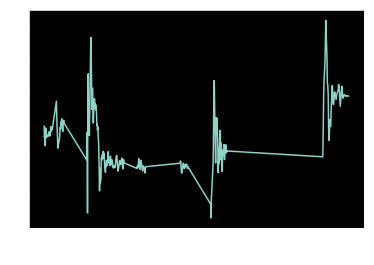

In [18]:
plt.plot(df_acc_sample[df_acc_sample.window_id==0].timestamp, f(df_acc_sample[df_acc_sample.window_id==0].timestamp))

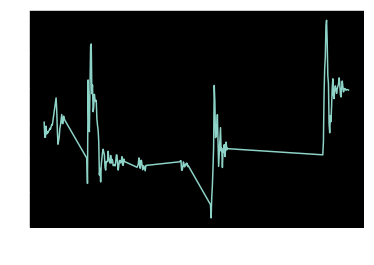

In [19]:
xnew = []
step = (df_acc_sample[df_acc_sample.window_id==0].timestamp.iloc[-1] - df_acc_sample[df_acc_sample.window_id==0].timestamp.iloc[0]) / df_acc_sample[df_acc_sample.window_id==0].index.size
for i in range(df_acc_sample[df_acc_sample.window_id==0].timestamp.iloc[0], df_acc_sample[df_acc_sample.window_id==0].timestamp.iloc[-1], int(step)):
    xnew.append(i)
plt.plot(xnew, f(xnew))

In [21]:
np.mean(np.real( fftpack.fft(df_acc_sample[df_acc_sample.window_id==0].double_x, 512)))

2.03271484375

In [ ]:
sgnal = f(xnew)
L = len(sgnal)
freqs, Pxx_den = signal.periodogram(sgnal, window=signal.get_window('boxcar', len(sgnal)), fs=8.1)
plt.semilogy(freqs, Pxx_den)
plt.ylim([1e-5, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [ ]:
int_fs = np.argwhere((freqs >= 0.5) & (freqs <= 3))
freqs_int = freqs[int_fs]
pdd = Pxx_den[int_fs]
np.argmax(pdd)
freqs_int[14]

In [ ]:
lmbs_f = np.linspace(0.5, 3, 10000)
pgram = signal.lombscargle(df_acc_sample[df_acc_sample.window_id==0].timestamp, df_acc_sample[df_acc_sample.window_id==0].double_x, lmbs_f, normalize=True)
plt.plot(lmbs_f, pgram)
lmbs_f[np.argmax(pgram)]

In [ ]:
Pxx_den = Pxx_den

In [ ]:
np.mean(Pxx_den) # PSD 

In [ ]:
Y = fftpack.fft(sgnal, 512)
np.dot(np.real(Y), np.real(Y))

In [ ]:
(np.sum(np.real(Y)**2 + np.imag(Y)**2)) / L

In [ ]:
np.sqrt(np.real(Y)**2  + np.imag(Y)**2) / np.sum(np.sqrt(np.real(Y)**2  + np.imag(Y)**2))

In [ ]:
LA.norm(np.mean(Y[1:]))

In [ ]:
f, Pxx_spec = signal.periodogram(sgnal, 8.1, 'flattop', scaling='spectrum')
plt.figure()
plt.semilogy(f, np.sqrt(Pxx_spec))
plt.xlabel('frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
plt.show()

In [ ]:
np.mean(Pxx_spec)

In [ ]:
Amplitude = np.abs(sig_fft)
psd = Amplitude**2
Angle = np.angle(sig_fft)

In [ ]:
sample_freq = fftpack.fftfreq(f(xnew).size, d=0.05)
sample_freq

In [ ]:
df_feature_windows.index.size

In [ ]:
ld = OrderedDict()
ld.update({'min':True})

In [ ]:
if ld['min']:
    print("yes")

In [ ]:
xx= ['int_desc', 'int_rms', 'mag_desc', 'pear_coef', 'sma', 'svm', 'ecdf_5', 'dc_comp', 'psd', 'psd_welch', 'psd_ls']

In [ ]:
for x in xx:
    print(x)

In [24]:
import matplotlib.pyplot as plt
A = 2.
w = 1.
phi = 0.5 * np.pi
nin = 1000
nout = 100000
frac_points = 0.9 # Fraction of points to select
r = np.random.rand(nin)
x = np.linspace(0.01, 10*np.pi, nin)
x = x[r >= frac_points]
x

array([ 0.26149891,  0.57587255,  0.73305937,  0.89024619,  1.20461983,
        1.33036928,  1.61330556,  1.64474292,  1.9276792 ,  2.49355175,
        2.68217593,  2.7136133 ,  2.80792539,  3.34236057,  3.37379794,
        3.65673421,  5.22860241,  5.44866395,  5.70016287,  5.85734969,
        6.64328378,  7.36634315,  7.42921788,  7.49209261,  7.55496734,
        8.18371461,  8.21515198,  8.87533662,  9.22114762,  9.37833444,
        9.91276963, 10.13283118, 10.98164   , 11.07595209, 11.17026418,
       11.29601364, 11.45320046, 11.67326201, 12.30200928, 12.74213238,
       12.86788184, 13.49662911, 14.25112585, 14.69124894, 16.6403655 ,
       16.73467759, 16.76611496, 16.79755232, 16.89186441, 17.14336333,
       17.20623805, 17.4262996 , 17.45773696, 17.92929742, 17.96073479,
       19.02960516, 19.18679198, 19.75266453, 19.90985135, 20.41284917,
       20.72722281, 21.32453272, 21.79609318, 22.07902946, 22.55058992,
       23.17933719, 23.24221192, 23.77664711, 24.24820757, 24.84

In [25]:
y = A * np.sin(w*x+phi)

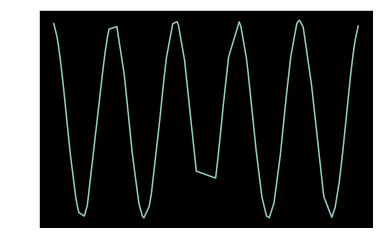

In [26]:
plt.plot(x,y)

In [27]:
f = np.linspace(0.01, 10, nout)
f

array([ 0.01     ,  0.0100999,  0.0101998, ...,  9.9998002,  9.9999001,
       10.       ])

In [28]:
import scipy.signal as signal
pgram = signal.lombscargle(x, y, f, normalize=False)

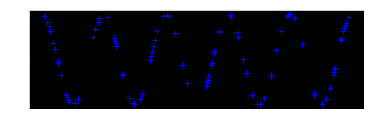

In [29]:
plt.subplot(2, 1, 1)
plt.plot(x, y, 'b+')

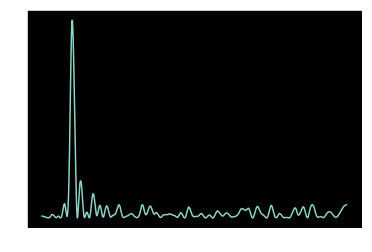

In [30]:
plt.plot(f, pgram)


In [ ]:
np.max(pgram)
f[np.argmax(pgram)]

In [31]:
x

array([ 0.26149891,  0.57587255,  0.73305937,  0.89024619,  1.20461983,
        1.33036928,  1.61330556,  1.64474292,  1.9276792 ,  2.49355175,
        2.68217593,  2.7136133 ,  2.80792539,  3.34236057,  3.37379794,
        3.65673421,  5.22860241,  5.44866395,  5.70016287,  5.85734969,
        6.64328378,  7.36634315,  7.42921788,  7.49209261,  7.55496734,
        8.18371461,  8.21515198,  8.87533662,  9.22114762,  9.37833444,
        9.91276963, 10.13283118, 10.98164   , 11.07595209, 11.17026418,
       11.29601364, 11.45320046, 11.67326201, 12.30200928, 12.74213238,
       12.86788184, 13.49662911, 14.25112585, 14.69124894, 16.6403655 ,
       16.73467759, 16.76611496, 16.79755232, 16.89186441, 17.14336333,
       17.20623805, 17.4262996 , 17.45773696, 17.92929742, 17.96073479,
       19.02960516, 19.18679198, 19.75266453, 19.90985135, 20.41284917,
       20.72722281, 21.32453272, 21.79609318, 22.07902946, 22.55058992,
       23.17933719, 23.24221192, 23.77664711, 24.24820757, 24.84